<a href="https://colab.research.google.com/github/mostafa-ja/Machine-Learning-fall2023/blob/main/ML_presentation5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Load Dataset

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 119977235.00it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 13968599.38it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34139063.07it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9636079.30it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [11]:
print(len(mnist_train))
print(len(mnist_test))

60000
10000


#Model Architecture and Training

In [14]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)


In [15]:
def epoch(loader, model, opt=None):
    total_loss, total_correct = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_correct += (yp.max(dim=1)[1] == y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_correct / len(loader.dataset), total_loss / len(loader.dataset)

In [16]:
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
print('train_accuracy\ttrain_loss\ttest_accuracy\ttest_loss')
for t in range(10):
    train_acc, train_loss = epoch(train_loader, model_cnn, opt)
    test_acc, test_loss = epoch(test_loader, model_cnn)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_acc, train_loss, test_acc, test_loss)), sep="\t")

train_accuracy	train_loss	test_accuracy	test_loss
0.799950	0.606913	0.968700	0.097727
0.974267	0.084617	0.977700	0.070817
0.982050	0.056942	0.983000	0.052794
0.986433	0.042292	0.986800	0.043727
0.989183	0.033773	0.986100	0.041210
0.994850	0.016693	0.989100	0.033476
0.996317	0.013334	0.990200	0.032797
0.996917	0.011889	0.988800	0.033365
0.997183	0.010760	0.989500	0.033675
0.997550	0.009794	0.989300	0.034523


In [17]:
# Function to calculate accuracy
def calculate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient tracking
        for inputs, labels in data_loader:
            inputs = inputs.to(device)  # Move inputs to GPU/CPU if available
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Assuming test_loader contains the test dataset
accuracy = calculate_accuracy(model_cnn, test_loader)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 98.93%


In [19]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

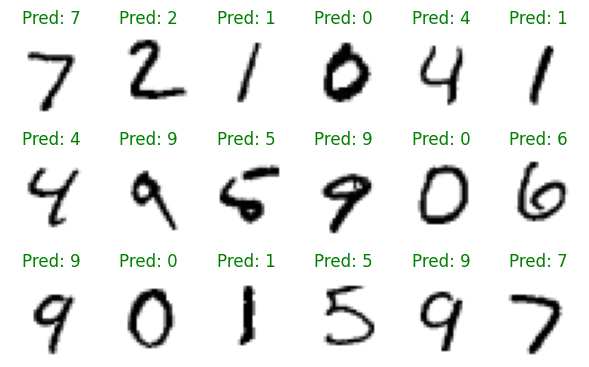

In [20]:
### Illustrate original predictions
yp = model_cnn(X)
plot_images(X, y, yp, 3, 6)

#Adversarial Attacks

In [22]:
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_correct = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)

        total_correct += (yp.max(dim=1)[1] == y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_correct / len(loader.dataset), total_loss / len(loader.dataset)

FGSM Attack

In [18]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [23]:
print("Accuracy on FGSM adversarial attack:", epoch_adversarial(model_cnn, test_loader, fgsm, 0.1)[0])

Accuracy on FGSM adversarial attack: 0.5335


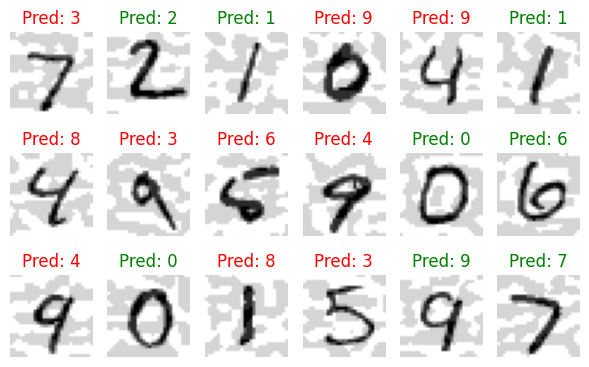

In [21]:
### Illustrate attacked images
delta = fgsm(model_cnn, X, y, 0.1)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

PGD Attack

In [26]:
def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [27]:
print("Accuracy on PGD adversarial attack:", epoch_adversarial(model_cnn, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])

Accuracy on PGD adversarial attack: 0.2701


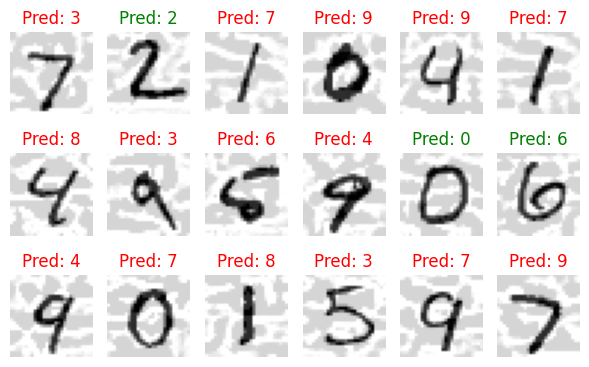

In [28]:
### Illustrate attacked images
delta = pgd_linf(model_cnn, X, y, epsilon=0.1, alpha=1e-2, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [ ]:
pgd_attack_range = np.arange(0.0, 0.52, 0.025)
pgd_acc = []
for eps in pgd_attack_range:
    pgd_acc.append(epoch_adversarial(model_cnn, test_loader, pgd_linf, eps, 1e-2, 40)[0])

In [ ]:
iter_fgsm_attack_range = np.arange(0.0, 0.52, 0.025)
iter_fgsm_acc = []
for eps in iter_fgsm_attack_range:
    iter_fgsm_acc.append(epoch_adversarial(model_cnn, test_loader, fgsm, eps)[0])

In [ ]:
with plt.style.context('ggplot'):
    fig, axes = plt.subplots(figsize=(10, 7))  # Create a figure and axes

    axes.set_title('$L^{\infty}$- Normal training')  # Set title using axes
    axes.plot(pgd_attack_range, pgd_acc, label='pgd_attack')
    axes.plot(iter_fgsm_attack_range, iter_fgsm_acc, label='fgsm_attack')
    # axes.vlines([3], 0, 1, colors=COLOURS[1], linestyle='--')  # Not clear what COLOURS represents
    axes.set_ylabel('Accuracy')
    axes.set_xlabel('Epsilon')
    axes.set_ylim((0, 1))
    axes.legend()

    plt.show()

#Adversarial training with adversarial examples

In [ ]:
def epoch_adversarial(loader, model, attack, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [ ]:
model_cnn_robust = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                                 nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                 Flatten(),
                                 nn.Linear(7*7*64, 100), nn.ReLU(),
                                 nn.Linear(100, 10)).to(device)

In [ ]:
def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)

    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [ ]:
opt = optim.SGD(model_cnn_robust.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch_adversarial(train_loader, model_cnn_robust, pgd_linf, opt)
    test_err, test_loss = epoch(test_loader, model_cnn_robust)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn_robust, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_cnn_robust.state_dict(), "model_cnn_robust.pt")

0.457100	0.033200	0.100600
0.077267	0.017000	0.058100
0.048950	0.015100	0.047100
0.037133	0.012500	0.035000
0.028800	0.010000	0.029900
0.019100	0.008700	0.027000
0.017517	0.008500	0.026500
0.016683	0.008700	0.026800
0.015867	0.008700	0.026400
0.015733	0.008800	0.026600


In [ ]:
# Assuming test_loader contains the test dataset
accuracy = calculate_accuracy(model_cnn_robust, test_loader)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 99.12%


In [ ]:
# Assuming test_loader contains the test dataset
accuracy =1 - epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, num_iter=40)[0]
print(f"Accuracy on PGD attack: {accuracy * 100:.2f}%")

Accuracy on PGD attack: 97.32%


In [ ]:
pgd_acc_linf = []
for eps in pgd_attack_range:
    pgd_acc_linf.append(1 - epoch_adversarial(test_loader, model_cnn_robust, pgd_linf,epsilon=eps,num_iter=100)[0])

In [ ]:
iter_fgsm_acc_linf = []
for eps in iter_fgsm_attack_range:
    iter_fgsm_acc_linf.append(1 - epoch_adversarial(test_loader, model_cnn_robust, fgsm,epsilon=eps)[0])

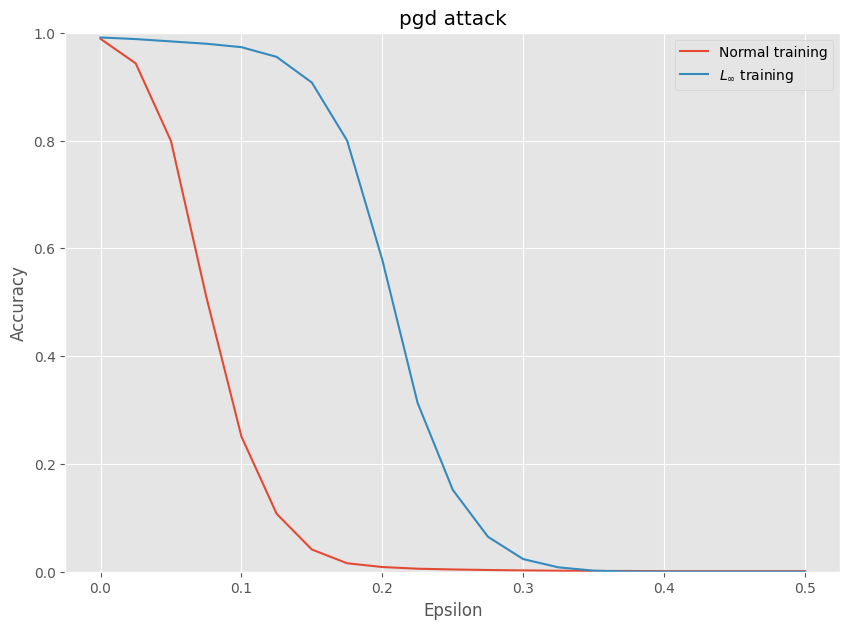

In [ ]:
import matplotlib.pyplot as plt

with plt.style.context('ggplot'):
    fig, axes = plt.subplots(figsize=(10, 7))  # Create a figure and axes

    axes.set_title('pgd attack')  # Set title using axes
    axes.plot(pgd_attack_range, pgd_acc, label='Normal training')
    axes.plot(pgd_attack_range, pgd_acc_linf, label='$L_{\infty}$ training')
    # axes.vlines([3], 0, 1, colors=COLOURS[1], linestyle='--')  # Not clear what COLOURS represents
    axes.set_ylabel('Accuracy')
    axes.set_xlabel('Epsilon')
    axes.set_ylim((0, 1))
    axes.legend()

    plt.show()


In [ ]:
for X,y in test_loader:
    X_test,y_test = X.to(device), y.to(device)
    break

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

def visualise_gradients(X_test, y_test, data_index):
    _x = X_test[data_index]
    _y = y_test[data_index]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    x = _x.unsqueeze(0).to(device).requires_grad_(True)
    y = _y.unsqueeze(0).to(device)

    axes[0].imshow(_x.squeeze().detach().cpu().numpy())
    axes[0].set_title('Original Picture ')
    axes[0].axis('off')  # Turn off the axis values

    y_pred = model_cnn(x)
    loss = nn.CrossEntropyLoss()(y_pred, y)
    loss.backward()
    axes[1].imshow(x.grad[0, 0].detach().cpu().numpy())
    axes[1].set_title('Original Model Gradient')
    axes[1].axis('off')  # Turn off the axis values

    x = _x.unsqueeze(0).to(device).requires_grad_(True)
    y = _y.unsqueeze(0).to(device)
    y_pred = model_cnn_robust(x.clone())
    loss = nn.CrossEntropyLoss()(y_pred, y)
    loss.backward()
    axes[2].imshow(x.grad[0, 0].detach().cpu().numpy())
    axes[2].set_title('Robust Model Gradient')
    axes[2].axis('off')  # Turn off the axis values



    plt.tight_layout()
    plt.show()


In [ ]:
_x = X_test[0]
_y = y_test[0]

x = _x.unsqueeze(0).to(device).requires_grad_(True)
y = _y.unsqueeze(0).to(device)

y_pred = model_cnn_robust(x)
loss = nn.CrossEntropyLoss()(y_pred, y)
loss.backward()

In [ ]:
x.grad.shape

torch.Size([1, 1, 28, 28])

In [ ]:
x.grad[0, 0].max()

tensor(9.1136e-06, device='cuda:0')

In [ ]:
x.grad[0, 0].min()

tensor(-1.3273e-05, device='cuda:0')

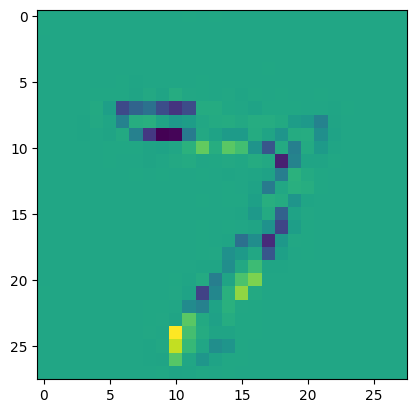

In [ ]:
plt.imshow(x.grad[0, 0].cpu()*10000)

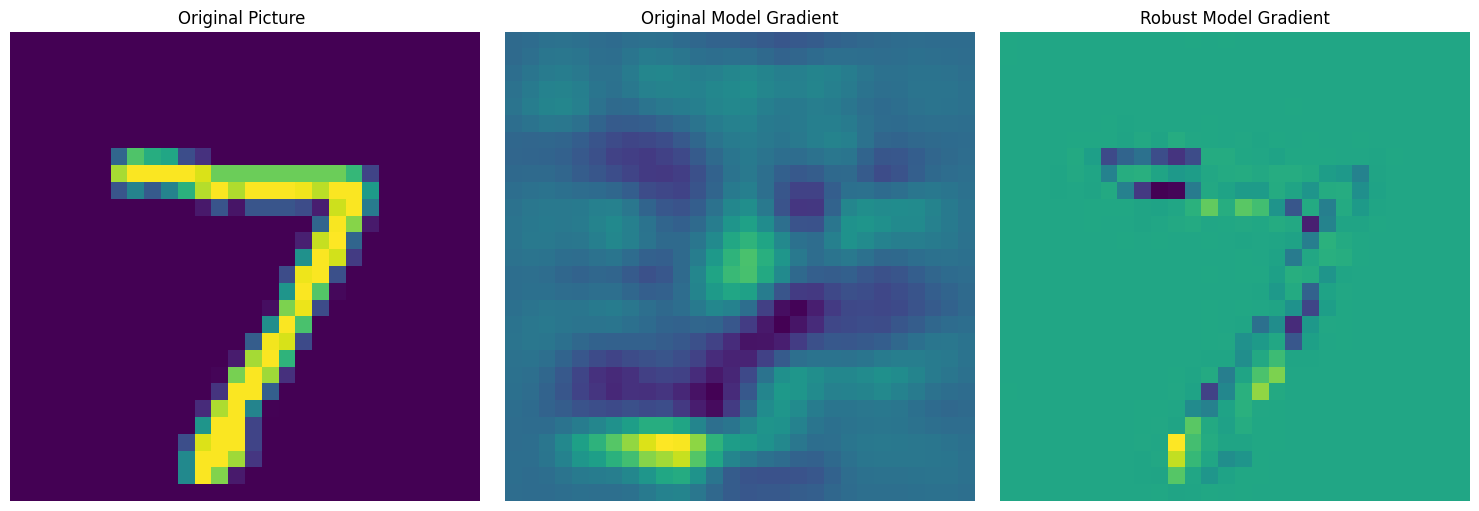

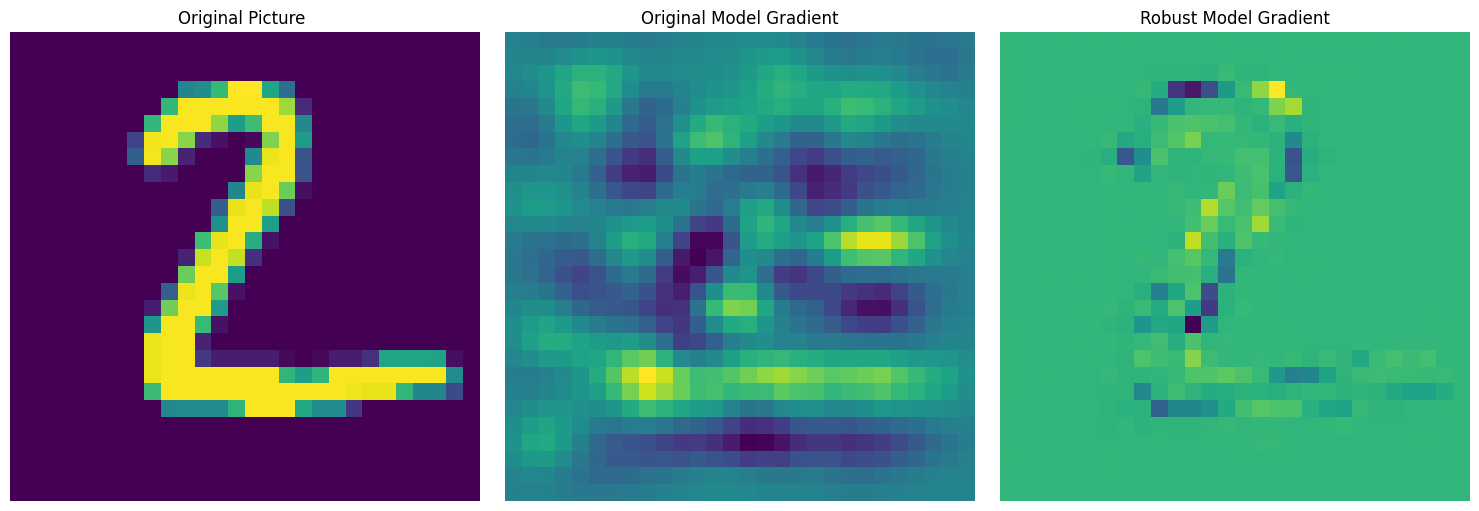

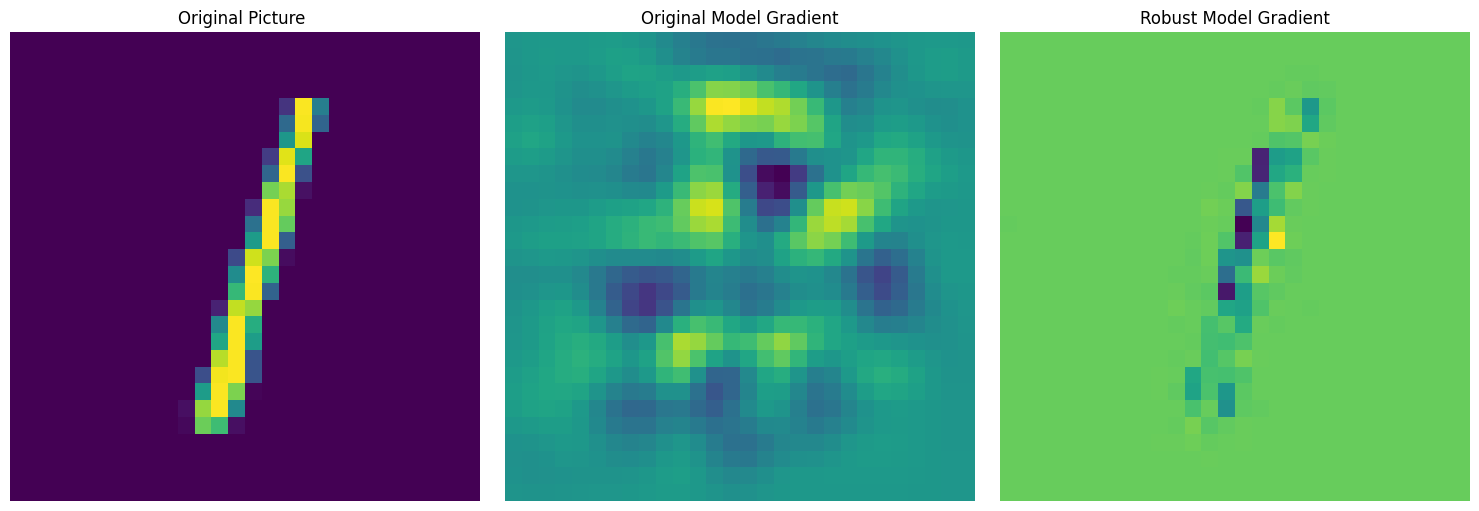

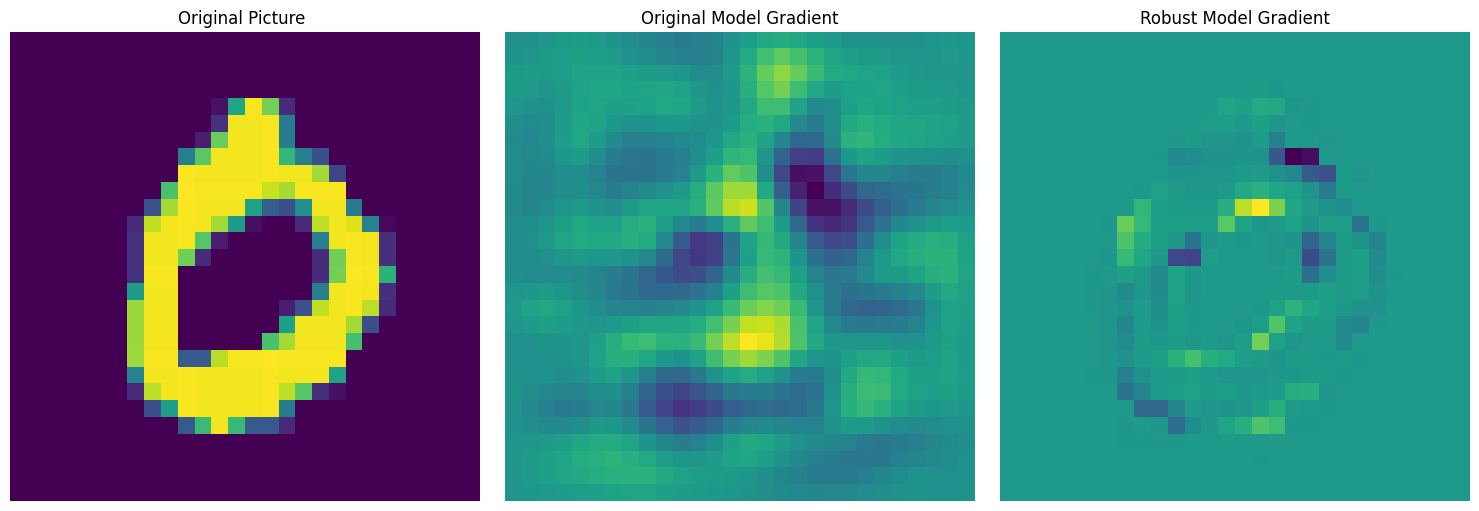

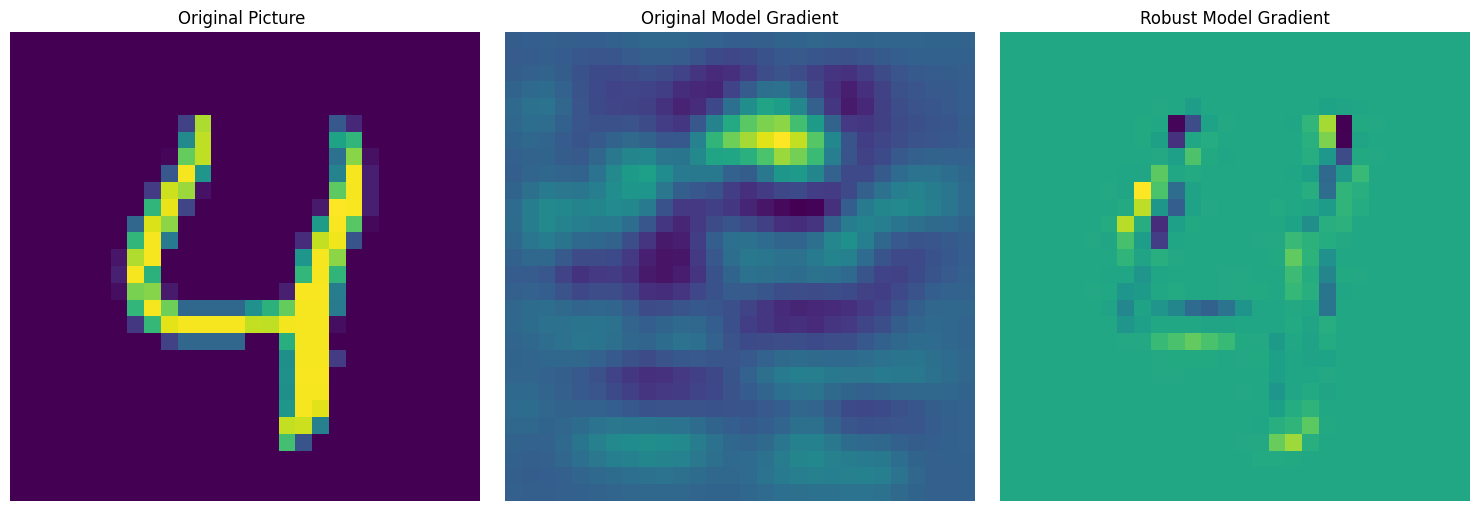

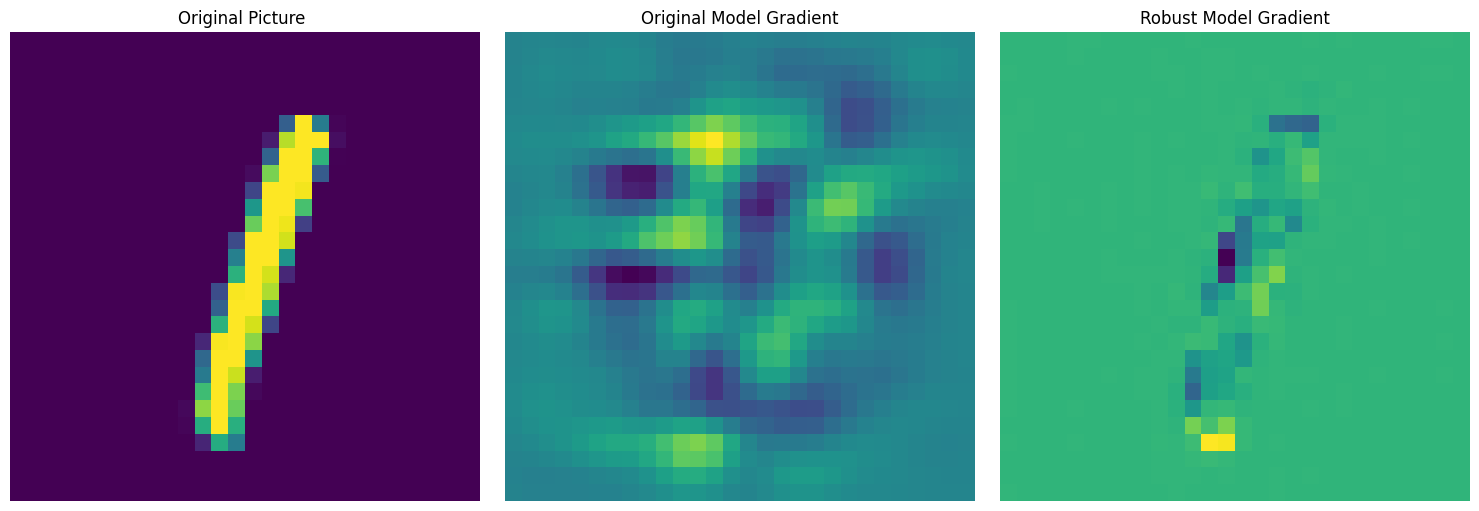

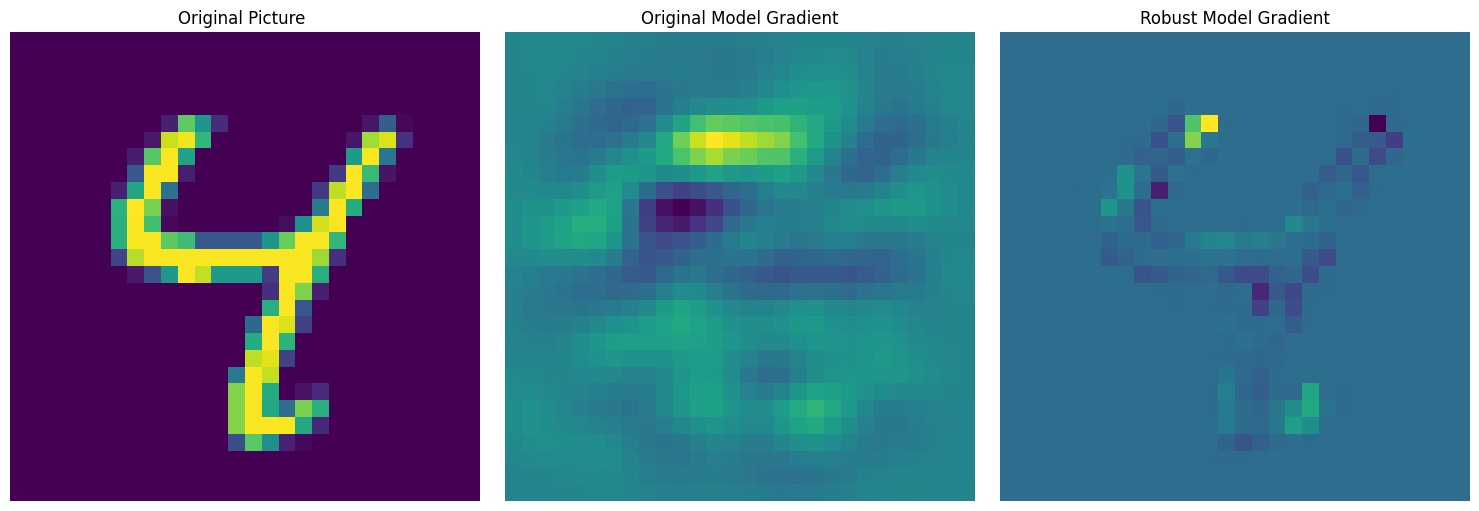

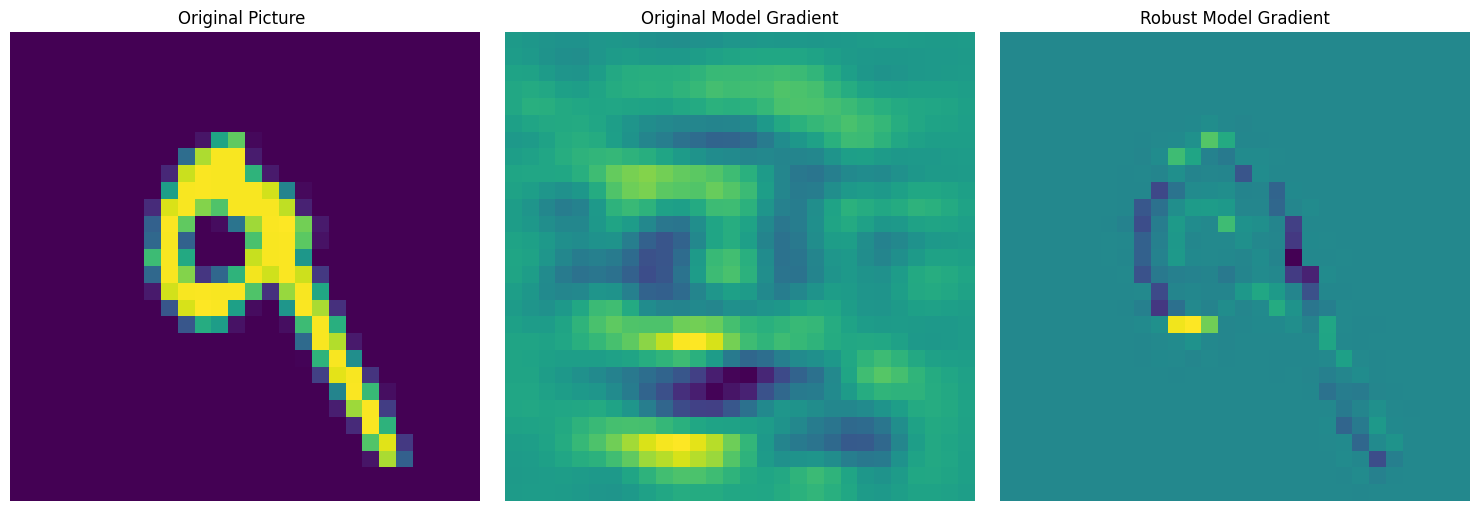

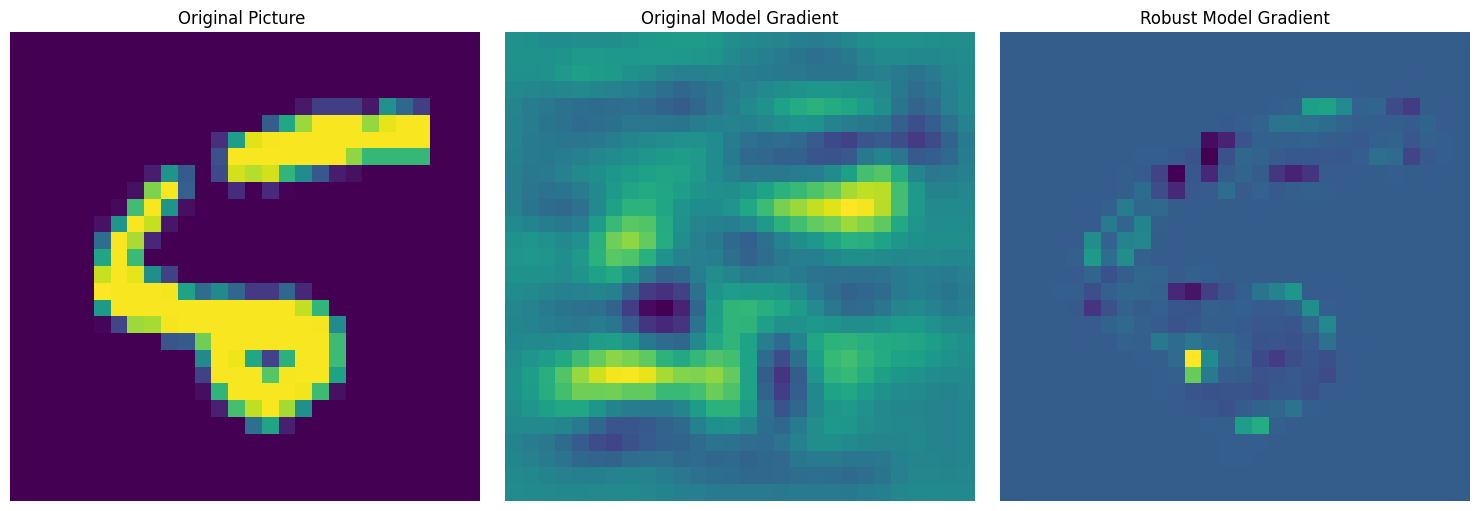

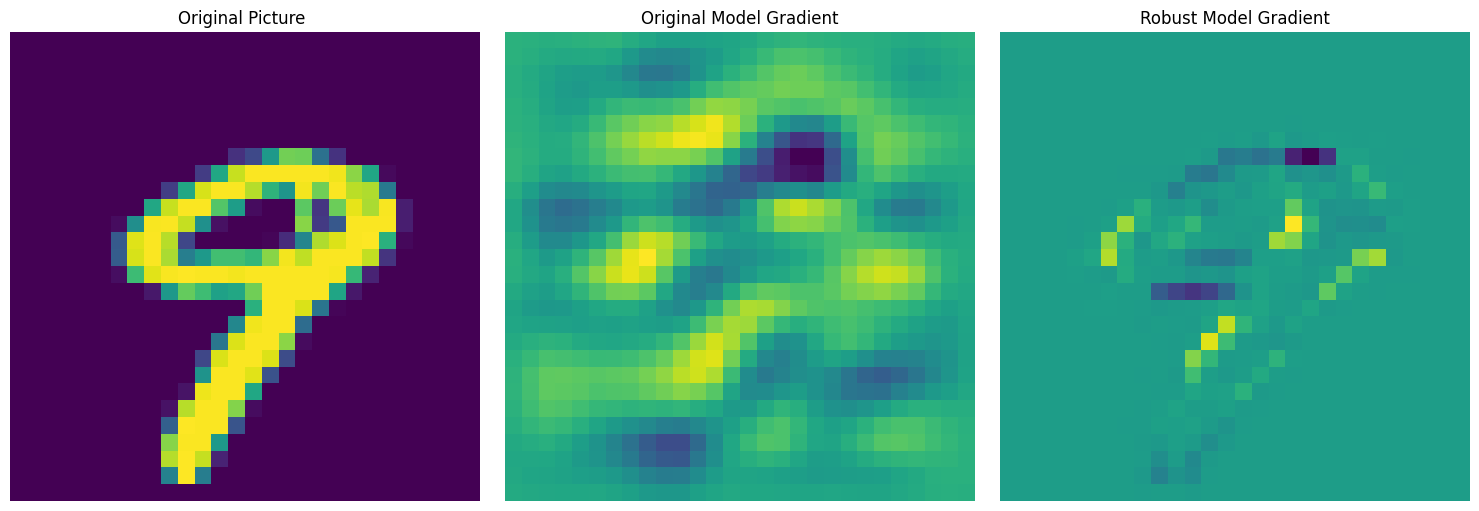

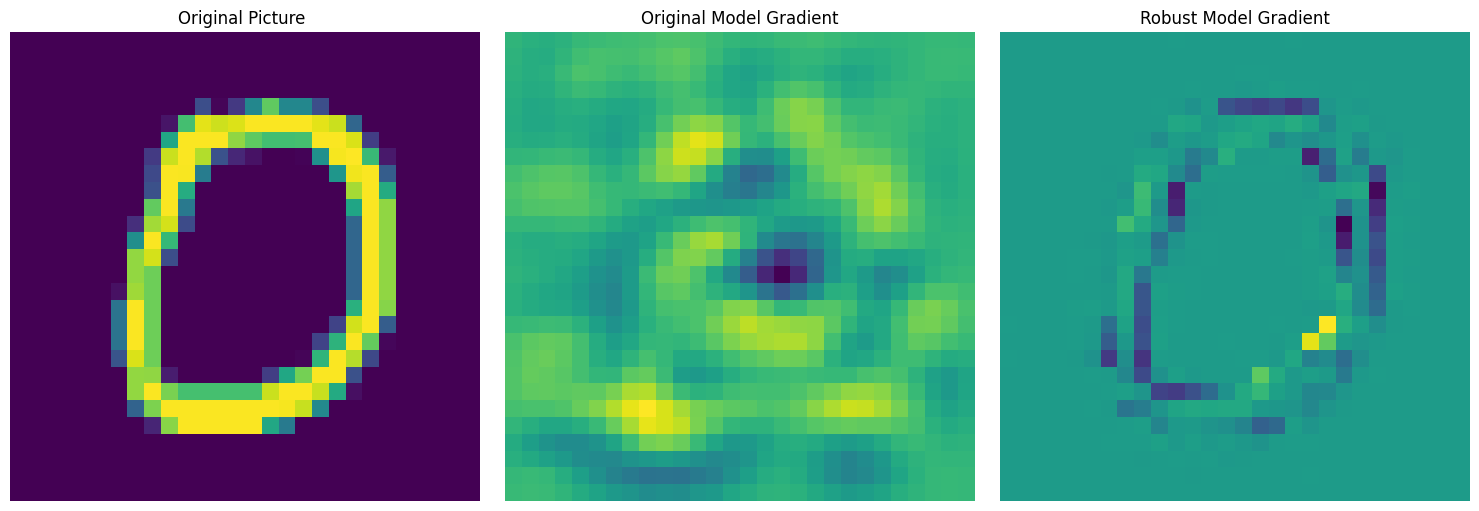

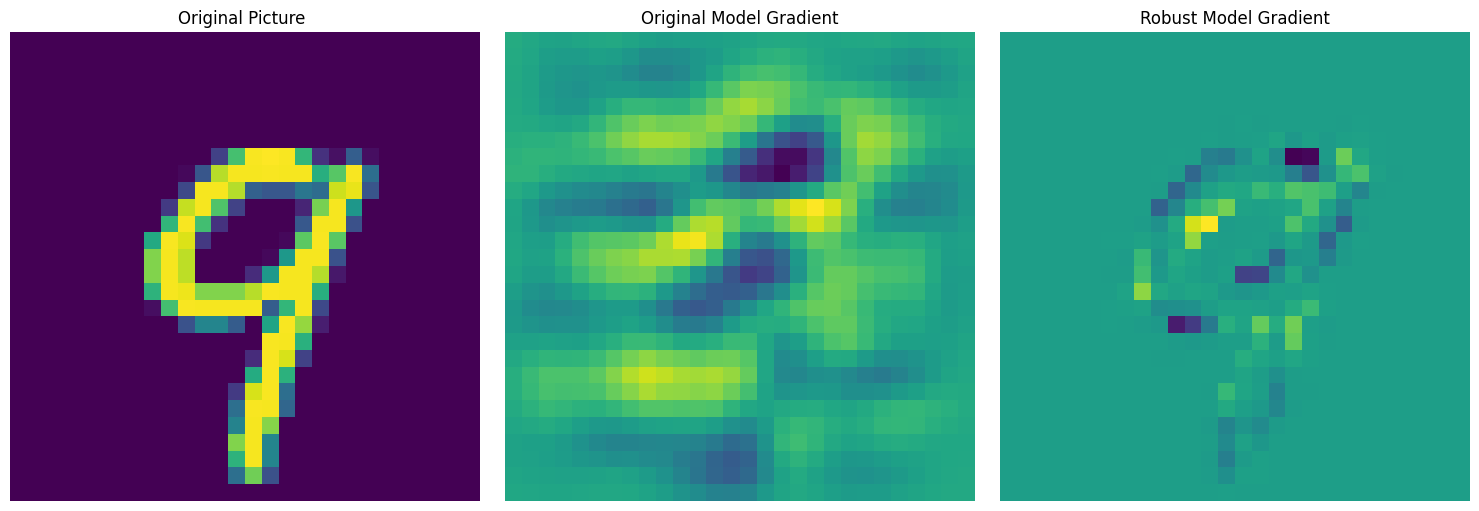

In [ ]:
visualise_gradients(X_test,y_test,0)
visualise_gradients(X_test,y_test,1)
visualise_gradients(X_test,y_test,2)
visualise_gradients(X_test,y_test,3)
visualise_gradients(X_test,y_test,4)
visualise_gradients(X_test,y_test,5)
visualise_gradients(X_test,y_test,6)
visualise_gradients(X_test,y_test,7)
visualise_gradients(X_test,y_test,8)
visualise_gradients(X_test,y_test,9)
visualise_gradients(X_test,y_test,10)
visualise_gradients(X_test,y_test,12)

In [ ]:
from matplotlib.colors import LightSource

def draw_loss(model, X, epsilon):
    Xi, Yi = np.meshgrid(np.linspace(-epsilon, epsilon,100), np.linspace(-epsilon,epsilon,100))

    def grad_at_delta(delta):
        delta.requires_grad_(True)
        nn.CrossEntropyLoss()(model(X+delta), y[0:1]).backward()
        return delta.grad.detach().sign().view(-1).cpu().numpy()

    dir1 = grad_at_delta(torch.zeros_like(X, requires_grad=True))
    delta2 = torch.zeros_like(X, requires_grad=True)
    delta2.data = torch.tensor(dir1).view_as(X).to(device)
    dir2 = grad_at_delta(delta2)
    np.random.seed(0)
    dir2 = np.sign(np.random.randn(dir1.shape[0]))

    all_deltas = torch.tensor((np.array([Xi.flatten(), Yi.flatten()]).T @
                              np.array([dir2, dir1])).astype(np.float32)).to(device)
    yp = model(all_deltas.view(-1,1,28,28) + X)
    Zi = nn.CrossEntropyLoss(reduction="none")(yp, y[0:1].repeat(yp.shape[0])).detach().cpu().numpy()
    Zi = Zi.reshape(*Xi.shape)
    #Zi = (Zi-Zi.min())/(Zi.max() - Zi.min())

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')  # Use add_subplot to create a 3D subplot
    ls = LightSource(azdeg=0, altdeg=200)
    rgb = ls.shade(Zi, plt.cm.coolwarm)

    surf = ax.plot_surface(Xi, Yi, Zi, rstride=1, cstride=1, linewidth=0,
                       antialiased=True, facecolors=rgb)

In [ ]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

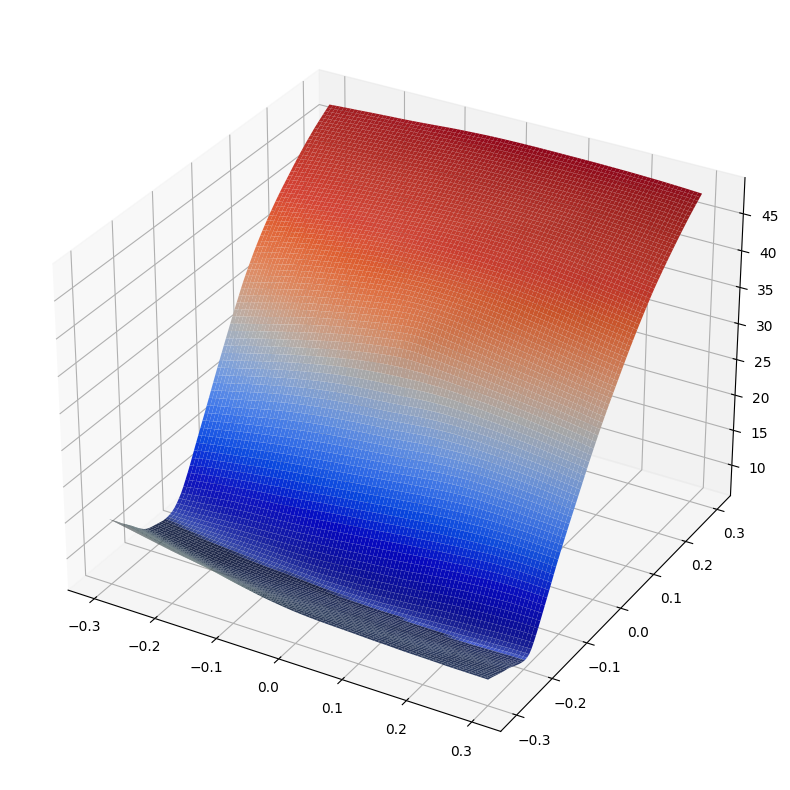

In [ ]:
draw_loss(model_cnn, X[1:2], 0.3)

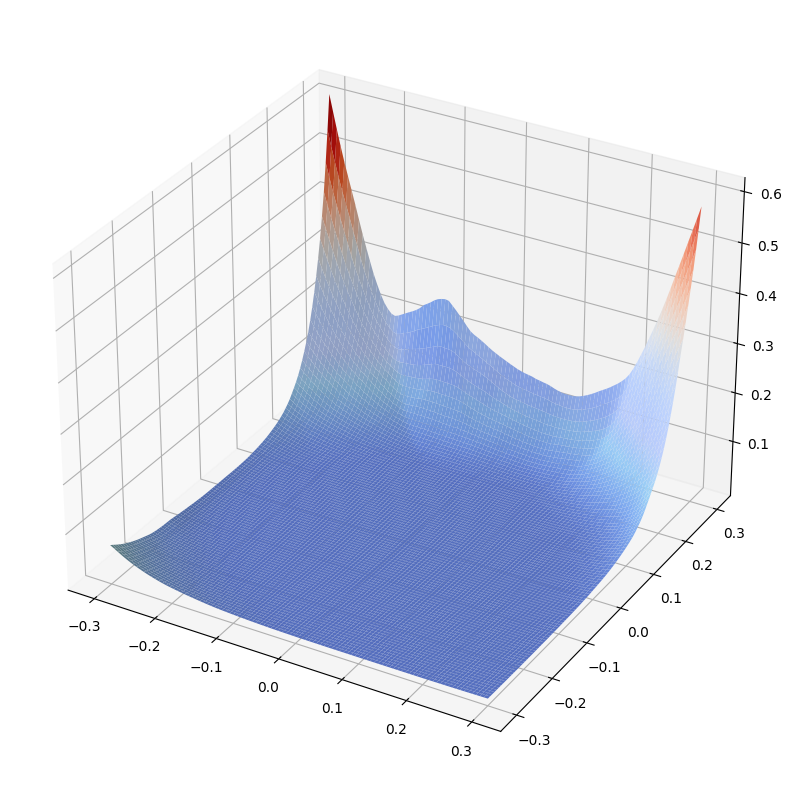

In [ ]:
draw_loss(model_cnn_robust, X[0:1], 0.3)

In [ ]:
Xi.shape

NameError: ignored

In [ ]:
y[0:1].shape

In [ ]:
all_deltas.shape

In [ ]:
x.shape

In [ ]:
epsilon = 0.1
Xi, Yi = np.meshgrid(np.linspace(-epsilon, epsilon,100), np.linspace(-epsilon,epsilon,100))

def grad_at_delta(delta):
    delta.requires_grad_(True)
    nn.CrossEntropyLoss()(model_cnn_robust(X[0:1]+delta), y[0:1]).backward()
    return delta.grad.detach().sign().view(-1).cpu().numpy()

dir1 = grad_at_delta(torch.zeros_like(X[0:1], requires_grad=True))
delta2 = torch.zeros_like(X[0:1], requires_grad=True)
delta2.data = torch.tensor(dir1).view_as(X[0:1]).to(device)
dir2 = grad_at_delta(delta2)
np.random.seed(0)
dir2 = np.sign(np.random.randn(dir1.shape[0]))

all_deltas = torch.tensor((np.array([Xi.flatten(), Yi.flatten()]).T @
                          np.array([dir2, dir1])).astype(np.float32)).to(device)
yp = model_cnn_robust(all_deltas.view(-1,1,28,28) + X[0:1])
Zi = nn.CrossEntropyLoss(reduction="none")(yp, y[0:1].repeat(yp.shape[0])).detach().cpu().numpy()
Zi = Zi.reshape(*Xi.shape)
